**AIM 5011 - Fall 2021**

**Final Project Component - Text-Only Meme Model with BERT (early stopping version)**

**Aishwarya Singh**

Preparation:

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
import re

In [2]:
repo = os.path.dirname(os.path.abspath(''))

In [3]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay

In [4]:
import tensorflow as tf
import keras as kr
import transformers

In [5]:
tf.config.list_physical_devices()

[PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU'),
 PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [6]:
from transformers import BertTokenizer, TFBertForSequenceClassification

In [7]:
tf.random.set_seed(0)
np.random.seed(0)

------------------------------------------------------------------------------------------

Encoder Functions:

In [8]:
# combine step for tokenization, WordPiece vector mapping, adding special tokens 
def convert_example_to_feature(review):
    return bert_tokenizer.encode_plus(review, 
                                    add_special_tokens = True,     # add [CLS], [SEP]
                                    max_length = 512,              # max length of the text that can go to BERT
                                    padding='max_length',
                                    truncation=True,
                                    return_attention_mask = True,  # add attention mask to not focus on pad tokens
                                  )

# map to the expected input to TFBertForSequenceClassification
def map_example_to_dict(input_ids, attention_masks, token_type_ids, label):
    return {
              "input_ids": input_ids,
              "token_type_ids": token_type_ids,
              "attention_mask": attention_masks,
          }, label

def encode_examples(ds):
    # prepare list, so that we can build up final TensorFlow dataset from slices.
    input_ids_list = []
    token_type_ids_list = []
    attention_mask_list = []
    label_list = []
    for review, label in ds:
        bert_input = convert_example_to_feature(review)
        input_ids_list.append(bert_input['input_ids'])
        token_type_ids_list.append(bert_input['token_type_ids'])
        attention_mask_list.append(bert_input['attention_mask'])
        label_list.append([label])

    return tf.data.Dataset.from_tensor_slices((input_ids_list, attention_mask_list, token_type_ids_list, label_list)).map(map_example_to_dict)

In [9]:
def extract_transform(frame):
    new_strings = []
    locate_capture = re.compile('description: "([\w\s]*)[\.\?!,]*"[\n]')
    
    for i in range(frame.shape[0]):
        new_strings.append(' '.join(locate_capture.findall(frame.iloc[i].text)))
    
    dataset = pd.DataFrame({'id':frame.Name, 'text':new_strings, 'label':frame.hate})
    return dataset

------------------------------------------------------------------------------------------

Data Load:

In [10]:
api_memes_list = []

for i in range(10):
    frame = pd.read_csv("https://raw.githubusercontent.com/codepharmer/AIM-5011-NLP-Final-Project/main/data/processed/google_API_response/facebook_images_API_response_" + str(i + 1) + ".csv")
    frame = frame[frame.text.notna()]
    
    print(frame.shape)
    
    api_memes_list.append(extract_transform(frame))

api_memes = pd.concat(api_memes_list).reset_index().drop('index', axis = 1)

api_memes.shape

(1214, 4)
(1214, 4)
(1212, 4)
(1211, 4)
(1214, 4)
(1212, 4)
(1214, 4)
(1212, 4)
(1214, 4)
(1213, 4)


(12130, 3)

In [11]:
api_memes

,id,text,label
0,08291.png,white people is this a shooting range,1
1,46971.png,bravery atits finest,1
2,03745.png,your order comes to and your white privilege d...,1
3,83745.png,it is time to send these parasites back to the...,1
4,80243.png,mississippi wind chime,1
...,...,...,...
12125,10423.png,nobody wants to hang,1
12126,98203.png,when god grants you a child after 20 years of ...,1
12127,36947.png,gays on social CUNFI Tettuality body positivit...,1
12128,16492.png,having a bad day you could be a siamese twin a...,1


In [12]:
api_memes.iloc[666].text

'we live in a society where they lecture us on morals and biology'

In [13]:
api_memes.label.sum()

4503

------------------------------------------------------------------------------------------

Model:

In [14]:
train_set, test_set = train_test_split(api_memes,
                                       test_size = 0.2,
                                       random_state = 0)

In [15]:
X_train = np.array(train_set.text)
y_train = np.array(train_set.label)

X_test = np.array(test_set.text)
y_test = np.array(test_set.label)

In [16]:
num_classes = 2

bert_tokenizer = BertTokenizer.from_pretrained("bert-base-uncased", do_lower_case = True)

In [17]:
# hyper-parameters
batch_size = 2

# recommended learning rate for Adam 5e-5, 3e-5, 2e-5
learning_rate = 1e-5

# multiple epochs might be better as long as we will not overfit the model
number_of_epochs = 2

In [18]:
# encode dataset
ds_train = zip(X_train, y_train)
ds_test = zip(X_test, y_test)
ds_train_encoded = encode_examples(ds_train).shuffle(len(X_train)).batch(batch_size)
ds_test_encoded = encode_examples(ds_test).batch(batch_size)

In [19]:
## Initialize pre-built BERT-based classifier from transformers
bert_model = TFBertForSequenceClassification.from_pretrained(
    'bert-base-uncased', num_labels = num_classes)

bert_model.summary()

All model checkpoint layers were used when initializing TFBertForSequenceClassification.

Some layers of TFBertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Model: "tf_bert_for_sequence_classification"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 bert (TFBertMainLayer)      multiple                  109482240 
                                                                 
 dropout_37 (Dropout)        multiple                  0         
                                                                 
 classifier (Dense)          multiple                  1538      
                                                                 
Total params: 109,483,778
Trainable params: 109,483,778
Non-trainable params: 0
_________________________________________________________________


In [20]:
# choosing Adam optimizer
optimizer = tf.keras.optimizers.Adam(learning_rate = learning_rate, epsilon = 1e-08)

# we do not have one-hot vectors, we can use sparse categorical cross entropy and accuracy
loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits = True)
metric = tf.keras.metrics.SparseCategoricalAccuracy('accuracy')

bert_model.compile(loss = loss,
                   optimizer = optimizer,
                   metrics = metric)

In [21]:
history = bert_model.fit(ds_train_encoded,
                         batch_size = batch_size,
                         epochs = number_of_epochs,
                         validation_data = ds_test_encoded)

Epoch 1/2
4852/4852 [==============================] - 2196s 448ms/step - loss: 0.6042 - accuracy: 0.6852 - val_loss: 0.5913 - val_accuracy: 0.6941
Epoch 2/2
4852/4852 [==============================] - 2178s 449ms/step - loss: 0.5247 - accuracy: 0.7400 - val_loss: 0.5662 - val_accuracy: 0.7065


Prediction & Evaluation:

In [22]:
# Export model
bert_model.save_weights(os.path.join(repo, "models", "BERTs", "bert_short.h5"))

In [23]:
y_test_pred = bert_model.predict(ds_test_encoded,
                                 batch_size = batch_size)

y_test_pred_label = y_test_pred[0].argmax(axis = 1)

Test Data Confusion Matrix:


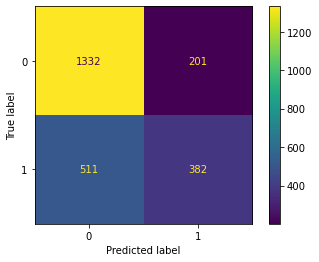

In [24]:
print("Test Data Confusion Matrix:")
figure = ConfusionMatrixDisplay(confusion_matrix(y_test, y_test_pred_label))
figure.plot()
plt.show()

In [25]:
X_all = np.array(api_memes.text)
y_all = np.array(api_memes.label)

# encode full dataset
ds_all = zip(X_all, y_all)
ds_all_encoded = encode_examples(ds_all).shuffle(len(X_all)).batch(batch_size)

In [26]:
y_all_pred = bert_model.predict(ds_all_encoded,
                                batch_size = batch_size)

y_all_pred_label = y_all_pred[0].argmax(axis = 1)

Whole Dataset Confusion Matrix:


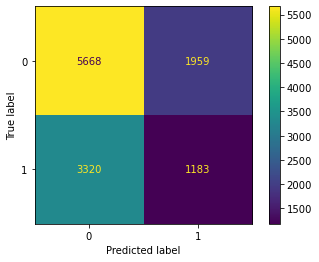

In [27]:
print("Whole Dataset Confusion Matrix:")
figure = ConfusionMatrixDisplay(confusion_matrix(y_all, y_all_pred_label))
figure.plot()
plt.show()

------------------------------------------------------------------------------------------

Export Results:

In [28]:
meme_text_outs = api_memes.copy()

meme_text_outs.insert(3, 'prediction', y_all_pred_label)
meme_text_outs.insert(4, 'pred_val0', np.array(y_all_pred[0][:,0]))
meme_text_outs.insert(5, 'pred_val1', np.array(y_all_pred[0][:,1]))

meme_text_outs

,id,text,label,prediction,pred_val0,pred_val1
0,08291.png,white people is this a shooting range,1,1,-0.148546,0.031935
1,46971.png,bravery atits finest,1,1,-0.880786,0.419983
2,03745.png,your order comes to and your white privilege d...,1,0,0.214836,-0.363764
3,83745.png,it is time to send these parasites back to the...,1,1,-0.302849,0.130118
4,80243.png,mississippi wind chime,1,1,-0.371248,0.187343
...,...,...,...,...,...,...
12125,10423.png,nobody wants to hang,1,0,0.233753,-0.255613
12126,98203.png,when god grants you a child after 20 years of ...,1,1,0.125389,0.332282
12127,36947.png,gays on social CUNFI Tettuality body positivit...,1,0,1.047033,-1.147389
12128,16492.png,having a bad day you could be a siamese twin a...,1,1,-0.776739,0.471085


In [29]:
meme_text_outs.to_csv(os.path.join(repo, "data", "processed", "Text_Processing_BERT_Facebook_data.csv"))